<a href="https://colab.research.google.com/github/AlexandreSeb97/CE203N-Spring2021/blob/main/CE203N_Final_Project_Payette_River.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE 203N Final Project: Flood Prediction on Payette River, Idaho
###Alexandre Erich Sébastien Georges
###UC Berkeley - Spring 2021
--------------------------------------------------------------------

# Code and Data Setup

### Importing required libraries

In [3]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install wget

import pandas as pd
import matplotlib.pyplot as plt
import math
import wget
import numpy as np
import seaborn as sns
import xarray as xr
#from mpl_toolkits.basemap import Basemap
from google.colab import files

# Scikit stuff
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

#Scikit metrics
from sklearn.metrics import mean_absolute_error, r2_score

### Downloading streamflow data from USGS Water Services and importing in Dataframe

In [4]:
filename = 'usgs.txt'
urlUSGS = "https://nwis.waterdata.usgs.gov/nwis/dv?cb_00060=on&cb_00065=on&cb_00095=on&format=rdb&site_no=08090800&referred_module=sw&period=&begin_date=2008-04-01&end_date=2021-04-18"
!wget -O usgs.txt "https://nwis.waterdata.usgs.gov/nwis/dv?cb_00060=on&cb_00065=on&cb_00095=on&format=rdb&site_no=13235000&referred_module=sw&period=&begin_date=1987-01-01&end_date=2021-04-18"


--2021-05-12 03:24:56--  https://nwis.waterdata.usgs.gov/nwis/dv?cb_00060=on&cb_00065=on&cb_00095=on&format=rdb&site_no=13235000&referred_module=sw&period=&begin_date=1987-01-01&end_date=2021-04-18
Resolving nwis.waterdata.usgs.gov (nwis.waterdata.usgs.gov)... 137.227.241.66, 137.227.252.7
Connecting to nwis.waterdata.usgs.gov (nwis.waterdata.usgs.gov)|137.227.241.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘usgs.txt’

usgs.txt                [     <=>            ] 386.58K   210KB/s    in 1.8s    

2021-05-12 03:24:59 (210 KB/s) - ‘usgs.txt’ saved [395861]



In [5]:
df = pd.read_csv(filename, sep='\t', skiprows=28)
stage = 21 # Use site no to pull floodstage on the fly for other sites from https://waterwatch.usgs.gov/index.php?id=flood&sid=w__table&r=tx
df

,agency_cd,site_no,datetime,46150_00060_00003,46150_00060_00003_cd
0,5s,15s,20d,14n,10s
1,USGS,13235000,1987-01-01,272,A:e
2,USGS,13235000,1987-01-02,290,A:e
3,USGS,13235000,1987-01-03,296,A:e
4,USGS,13235000,1987-01-04,291,A:e
...,...,...,...,...,...
12523,USGS,13235000,2021-04-14,739,P
12524,USGS,13235000,2021-04-15,723,P
12525,USGS,13235000,2021-04-16,750,P
12526,USGS,13235000,2021-04-17,785,P


### Getting NOAA Precipitation Data and importing in Dataframe


In [6]:
uploaded = files.upload()
precipurl = 'https://github.com/AlexandreSeb97/CE203N-Spring2021/blob/main/precipdatabrazos.csv'
df_prec = pd.read_csv('climate_data_payette.csv')
df_prec

Saving climate_data_payette.csv to climate_data_payette.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES
0,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-01,NaN,NaN,1.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,",,T",7.0,",,T",NaN,NaN
1,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-02,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,",,T",7.0,",,T",NaN,NaN
2,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-03,NaN,NaN,0.5,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,",,T",7.3,",,T",NaN,NaN
3,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-04,NaN,NaN,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,",,T",7.4,",,T",NaN,NaN
4,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-05,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,",,T",7.4,",,T",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-26,NaN,NaN,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T",NaN,NaN
36882,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-27,NaN,NaN,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36883,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-28,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36884,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-29,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",NaN,NaN


## Data Cleanup and Merge

### USGS Cleanup 

Renaming Columns and dropping row 0 for easier data manipulation

In [7]:
df = df.rename(columns={'46150_00060_00003': 'DISCH'})
#df = df.rename(columns={'46150_00060_00003': 'DISCH', '134940_00060_00002': 'DISCHMIN', '134939_00060_00001': 'DISCHMAX'})
#df = df.rename(columns={'134941_00060_00003_cd': 'DISCH_APPR', '134940_00060_00002_cd': 'DISCHMIN_APPR', '134939_00060_00001_cd': 'DISCHMAX_APPR'})
#df = df.rename(columns={'134944_00065_00003': 'GAGE', '134943_00065_00002': 'GAGEMIN', '134942_00065_00001': 'GAGEMAX'})
#df = df.rename(columns={'134944_00065_00003_cd': 'GAGE_APPR', '134943_00065_00002_cd': 'GAGEMIN_APPR', '134942_00065_00001_cd': 'GAGEMAX_APPR'})
df = df.drop(0)
df

,agency_cd,site_no,datetime,DISCH,46150_00060_00003_cd
1,USGS,13235000,1987-01-01,272,A:e
2,USGS,13235000,1987-01-02,290,A:e
3,USGS,13235000,1987-01-03,296,A:e
4,USGS,13235000,1987-01-04,291,A:e
5,USGS,13235000,1987-01-05,282,A:e
...,...,...,...,...,...
12523,USGS,13235000,2021-04-14,739,P
12524,USGS,13235000,2021-04-15,723,P
12525,USGS,13235000,2021-04-16,750,P
12526,USGS,13235000,2021-04-17,785,P


Changing object types to int, float, str and datetime

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
#df['GAGE'] = df['GAGE'].astype(float)
#df['GAGEMAX'] = df['GAGEMAX'].astype(float)
#df['GAGEMIN'] = df['GAGEMIN'].astype(float)
df['DISCH'] = df['DISCH'].replace(['Ice'], [0])
df['DISCH'] = df['DISCH'].astype(float)
#df['DISCHMAX'] = df['DISCHMAX'].astype(float)
#df['DISCHMIN'] = df['DISCHMIN'].astype(float)
df.dtypes

agency_cd                       object
site_no                         object
datetime                datetime64[ns]
DISCH                          float64
46150_00060_00003_cd            object
dtype: object

### NOAA Cleanup

Renaming DATE column to datetime

In [9]:
df_prec = df_prec.rename(columns={'DATE': 'datetime'})
df_prec

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,datetime,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES
0,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-01,NaN,NaN,1.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,",,T",7.0,",,T",NaN,NaN
1,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-02,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,",,T",7.0,",,T",NaN,NaN
2,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-03,NaN,NaN,0.5,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,",,T",7.3,",,T",NaN,NaN
3,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-04,NaN,NaN,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,",,T",7.4,",,T",NaN,NaN
4,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-05,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,",,T",7.4,",,T",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-26,NaN,NaN,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T",NaN,NaN
36882,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-27,NaN,NaN,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36883,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-28,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36884,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-29,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",NaN,NaN


Changing object types to datetime

In [10]:
df_prec['datetime'] = pd.to_datetime(df_prec['datetime'], errors='coerce')

### Merging NOAA and USGS on time

In [11]:
#df_prec.dtypes
newdf = df.merge(df_prec)
newdf

,agency_cd,site_no,datetime,DISCH,46150_00060_00003_cd,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES
0,USGS,13235000,1987-01-01,272.0,A:e,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,NaN,NaN,1.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,",,T",7.0,",,T",NaN,NaN
1,USGS,13235000,1987-01-01,272.0,A:e,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,1.8,",,T",NaN,NaN,26.0,",,T",29.0,",,T",22.0,",,T",22.0,",,T",7.1,",,T",NaN,NaN
2,USGS,13235000,1987-01-01,272.0,A:e,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,NaN,NaN,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",NaN,NaN
3,USGS,13235000,1987-01-02,290.0,A:e,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,",,T",7.0,",,T",NaN,NaN
4,USGS,13235000,1987-01-02,290.0,A:e,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,0.0,",,T",NaN,NaN,23.0,",,T",29.0,",,T",19.0,",,T",23.0,",,T",7.2,",,T",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,USGS,13235000,2020-08-29,398.0,A,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,0.0,",,T",0.0,",,T",63.0,",,T",76.0,",,T",51.0,",,T",56.0,",,T",0.0,",,T",NaN,NaN
36882,USGS,13235000,2020-08-29,398.0,A,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",NaN,NaN
36883,USGS,13235000,2020-08-30,391.0,A,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,0.0,",,T",0.0,",,T",0.0,",,T",53.0,",,T",62.0,",,T",45.0,",,T",46.0,",,T",0.0,",,T",0.4,",,T"
36884,USGS,13235000,2020-08-30,391.0,A,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,0.0,",,T",0.0,",,T",55.0,",,T",65.0,",,T",45.0,",,T",46.0,",,T",0.0,",,T",NaN,NaN


## Data Visualization

### Visualizing USGS Data

Pullin training and testing sets and adding DAY_OF_YEAR for seasonality analysis

In [12]:
newdf['DAY_OF_YEAR'] = newdf['datetime'].dt.dayofyear
train_df = newdf[newdf['datetime'].dt.year <= 2015]
test_df = newdf[newdf['datetime'].dt.year > 2015]
newdf

,agency_cd,site_no,datetime,DISCH,46150_00060_00003_cd,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES,DAY_OF_YEAR
0,USGS,13235000,1987-01-01,272.0,A:e,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,NaN,NaN,1.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,",,T",7.0,",,T",NaN,NaN,1
1,USGS,13235000,1987-01-01,272.0,A:e,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,1.8,",,T",NaN,NaN,26.0,",,T",29.0,",,T",22.0,",,T",22.0,",,T",7.1,",,T",NaN,NaN,1
2,USGS,13235000,1987-01-01,272.0,A:e,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,NaN,NaN,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",NaN,NaN,1
3,USGS,13235000,1987-01-02,290.0,A:e,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,",,T",7.0,",,T",NaN,NaN,2
4,USGS,13235000,1987-01-02,290.0,A:e,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,0.0,",,T",NaN,NaN,23.0,",,T",29.0,",,T",19.0,",,T",23.0,",,T",7.2,",,T",NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,USGS,13235000,2020-08-29,398.0,A,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,0.0,",,T",0.0,",,T",63.0,",,T",76.0,",,T",51.0,",,T",56.0,",,T",0.0,",,T",NaN,NaN,242
36882,USGS,13235000,2020-08-29,398.0,A,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",NaN,NaN,242
36883,USGS,13235000,2020-08-30,391.0,A,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,0.0,",,T",0.0,",,T",0.0,",,T",53.0,",,T",62.0,",,T",45.0,",,T",46.0,",,T",0.0,",,T",0.4,",,T",243
36884,USGS,13235000,2020-08-30,391.0,A,USS0015F01S,"MORES CREEK SUMMIT, ID US",43.93,-115.67,1859.3,NaN,NaN,0.0,",,T",0.0,",,T",55.0,",,T",65.0,",,T",45.0,",,T",46.0,",,T",0.0,",,T",NaN,NaN,243


Setting Datetime as Index


In [13]:
newdf = newdf.set_index('datetime')
train_df = train_df.set_index('datetime')
test_df = test_df.set_index('datetime')

#### Gage Height Timeseries

In [14]:
#fig, ax = plt.subplots(figsize=(15,15))

#ax.plot(newdf.index.values, newdf['GAGE'])
#plt.axhline(y = stage, color = 'r', linestyle = '-', label='Flood Stage')
#plt.fill_between(newdf.index.values, newdf['GAGEMAX'], newdf['GAGEMIN'],
   #              color='gray', alpha=0.7)

#ax.set(xlabel='Year',
  #     ylabel='Gage Height - m',
 #      title='Gage Height Timeseries')
#ax.legend()
#plt.grid()
#plt.show()

#### Discharge Timeseries

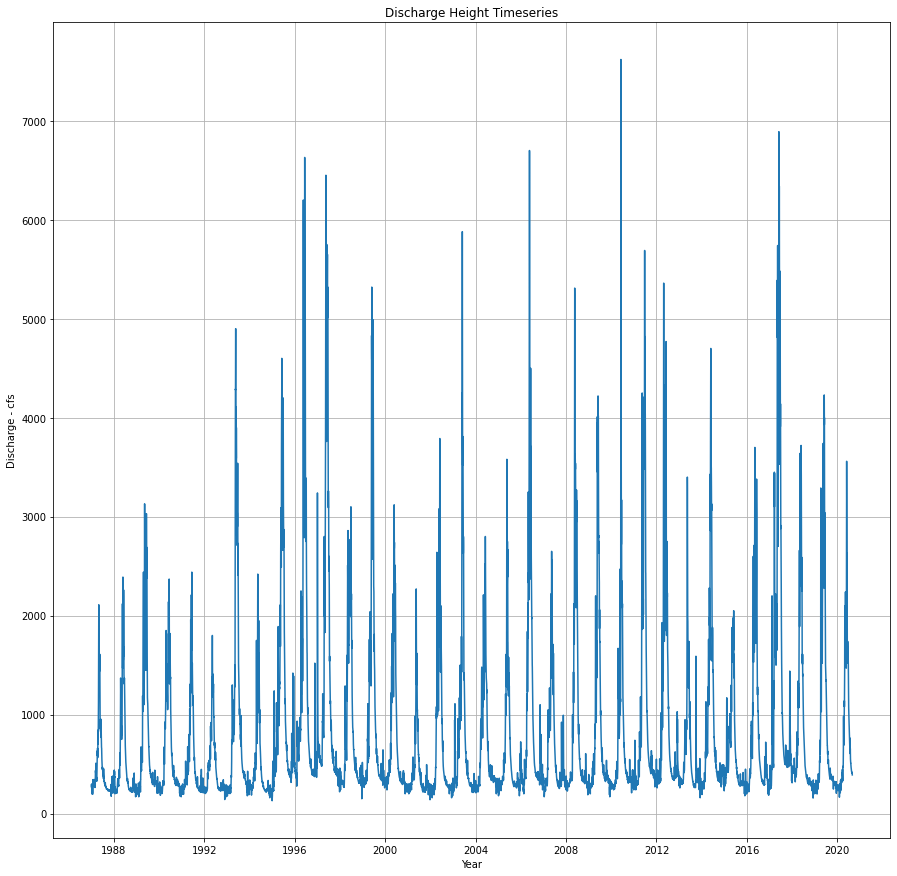

In [15]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(newdf.index.values, newdf['DISCH'])
#plt.fill_between(newdf.index.values, newdf['DISCHMIN'], newdf['DISCHMAX'],
 #                color='gray', alpha=0.7)

ax.set(xlabel='Year',
       ylabel='Discharge - cfs',
       title='Discharge Height Timeseries')
plt.grid()
plt.show()

#### Precipitation Timeseries

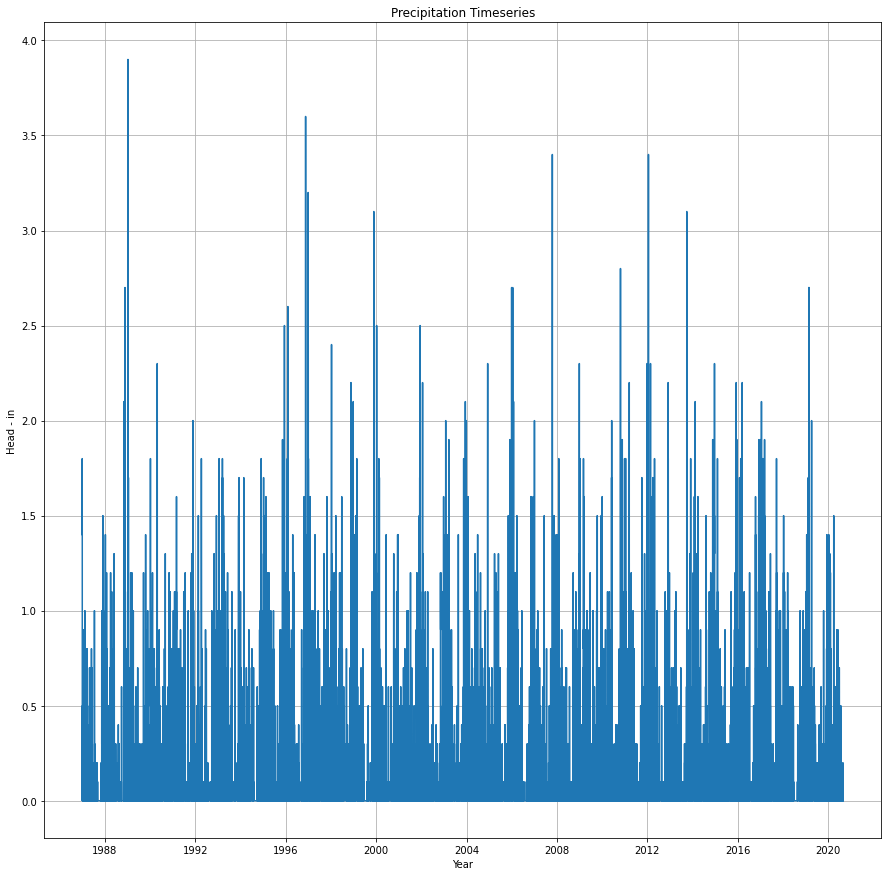

In [16]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(newdf.index.values, newdf['PRCP'])


ax.set(xlabel='Year',
       ylabel='Head - in',
       title='Precipitation Timeseries')
plt.grid()
plt.show()

# Precipition-Discharge Model Training

In [17]:
mean = newdf['DISCH'].mean()
mean

799.9080681017188

Evaluating Visualization

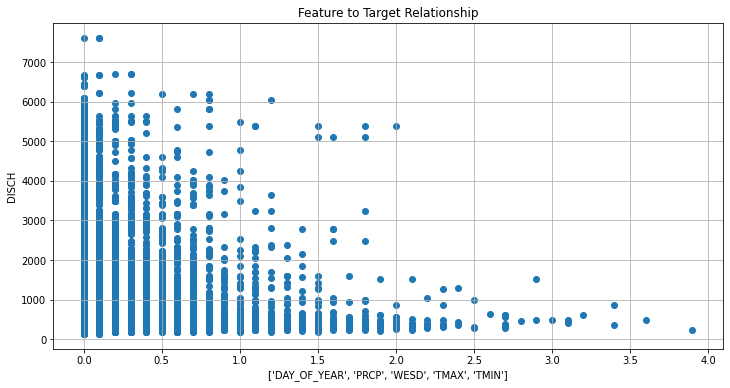

In [18]:
features = ['DAY_OF_YEAR', 'PRCP', 'WESD', 'TMAX', 'TMIN']
target = 'DISCH'

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(train_df['PRCP'], 
           train_df[target],)
ax.set(xlabel=features,
       ylabel=target,
       title="Feature to Target Relationship")
plt.grid()
plt.show()

## Linear Regression

In [19]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

x_train = train_df[features]
y_train = train_df[target]

x_test = test_df[features]
y_test = test_df[target]


x_test = imputer.fit_transform(x_test)
x_train = imputer.fit_transform(x_train)

x_train[np.isnan(x_train)] = np.median(x_train[~np.isnan(x_train)]) 
x_test[np.isnan(x_test)] = np.median(x_test[~np.isnan(x_test)])
x_test[np.isnan(x_test)] = np.median(x_test[~np.isnan(x_test)])
y_train[np.isnan(y_train)] = np.median(y_train[~np.isnan(y_train)])
y_test[np.isnan(y_test)] = np.median(y_test[~np.isnan(y_test)])
print(np.isnan(x_train).any(), np.isnan(y_train).any())

False False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
prediction = linear_model.predict(x_test)

In [21]:
mae_linear = mean_absolute_error(y_test, prediction)
r2_linear = r2_score(y_test, prediction)

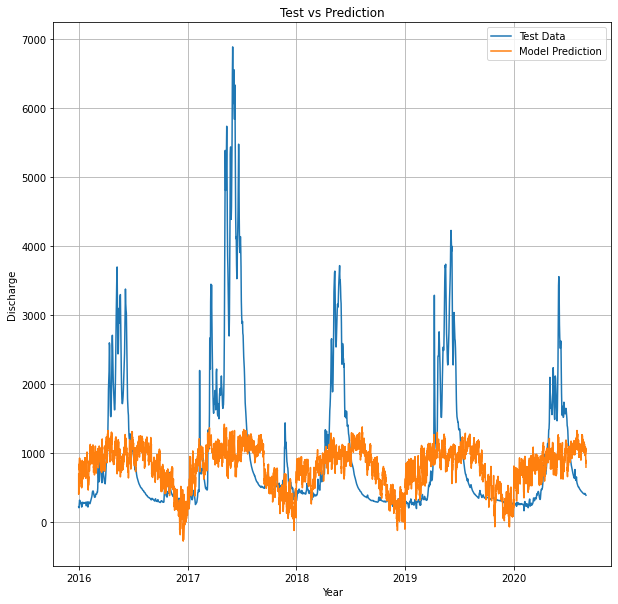

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(test_df.index.values, y_test, label='Test Data')
ax.plot(test_df.index.values, prediction, label='Model Prediction')
ax.set(xlabel='Year',
       ylabel='Discharge',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

##Polynomial Regression

In [23]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

poly_model = PolynomialRegression(5)
poly_model.fit(x_train, y_train)
poly_predic = poly_model.predict(x_test)

In [24]:
mae_poly = mean_absolute_error(y_test, poly_predic)
r2_poly = r2_score(y_test, poly_predic)

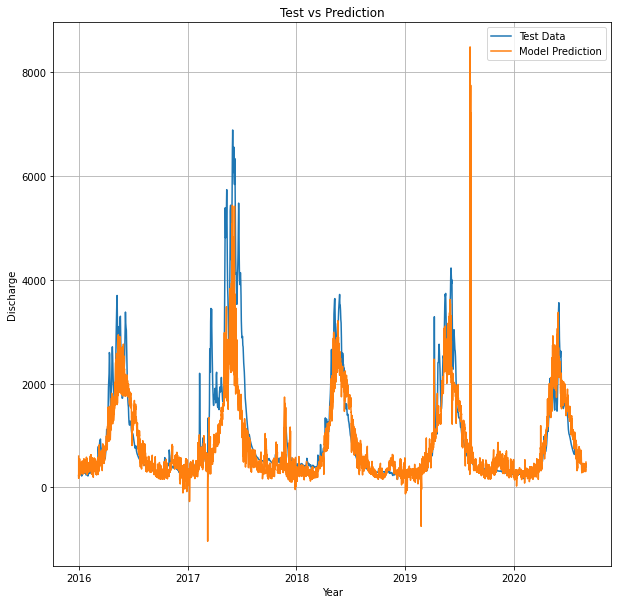

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(test_df.index.values, y_test, label='Test Data')
ax.plot(test_df.index.values, poly_predic, label='Model Prediction')
ax.set(xlabel='Year',
       ylabel='Discharge',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

## Random Forest

In [26]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [27]:
regressor = RandomForestRegressor(n_estimators=1000, random_state=250, min_samples_leaf=10)
regressor.fit(x_train, y_train)
random_predic = regressor.predict(x_test)

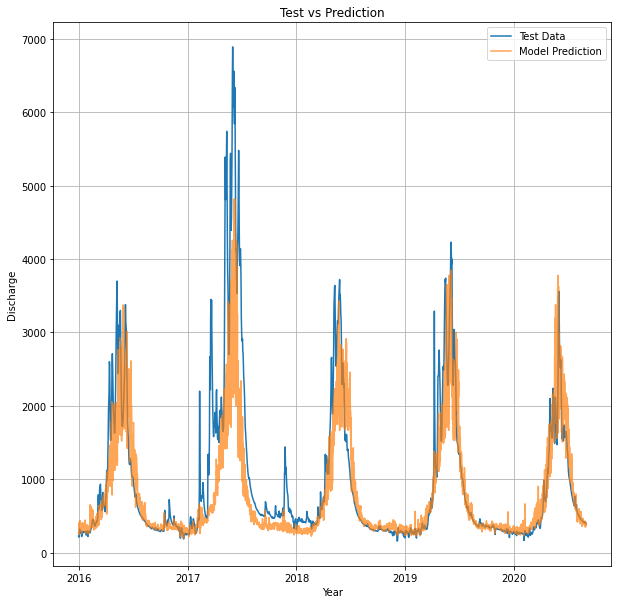

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(test_df.index.values, y_test, label='Test Data')
ax.plot(test_df.index.values, random_predic, label='Model Prediction', alpha=0.7)
ax.set(xlabel='Year',
       ylabel='Discharge',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

In [29]:
mae_random_forest = mean_absolute_error(y_test, random_predic)
r2_random_forest = r2_score(y_test, random_predic)

In [30]:
model_validation = {'Model Type': ['Linear Regression', 'Polynomial Regression (3)', 'Random Forest'], 
                       'MAE': [mae_linear, mae_poly, mae_random_forest], 
                       'R^2':[r2_linear, r2_poly, r2_random_forest]}

validation_df = pd.DataFrame(model_validation)
validation_df

,Model Type,MAE,R^2
0,Linear Regression,642.089709,0.106827
1,Polynomial Regression (3),336.580933,0.616998
2,Random Forest,316.677632,0.653680
